# 🧠 Parallelization Pattern

## **Concept**
Parallelization enables **concurrent execution** of independent sub-tasks (LLM calls, tool invocations, or sub-agents) to **reduce latency** and **boost efficiency** in agent workflows.

---

## **Key Idea**
Identify workflow components that **don’t depend on each other’s outputs** and execute them **simultaneously** instead of sequentially.

**Example:**
Instead of processing Source A → then Source B → then combining,
run **Source A and Source B in parallel**, summarize both, then synthesize results sequentially.

---

## **Technical Mechanisms**
- Use **asynchronous execution**, **multi-threading**, or **multi-processing**.  
- **LangChain (LCEL):** parallel runnables via concurrent branches.  
- **LangGraph:** parallel node execution from a single state transition.  
- **Google ADK:** native multi-agent concurrency and scheduling.

---

## **Benefits**
- Minimizes total execution time.  
- Handles API/database latency efficiently.  
- Improves responsiveness and scalability in agent systems.

---

## **Typical Use Cases**
1. **Information Gathering:** Query multiple data sources simultaneously.  
2. **Data Analysis:** Run sentiment, keyword, and category extraction in parallel.  
3. **Multi-API Calls:** Fetch flights, hotels, and events concurrently.  
4. **Content Generation:** Create subject, body, and visuals simultaneously.  
5. **Validation:** Perform independent input checks in parallel.  
6. **Multi-Modal Processing:** Analyze text, image, and audio together.  
7. **A/B Testing:** Generate multiple variants concurrently.

---

## **Takeaway**
Parallelization is a **core optimization pattern** for **agentic design**, enabling faster, more efficient, and scalable AI systems by leveraging concurrent execution of independent tasks.



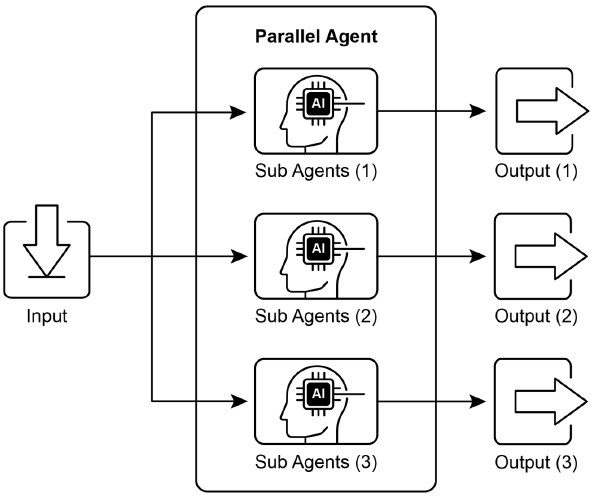

In [3]:
from typing import Annotated, TypedDict, Any
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image

import operator

In [2]:
load_dotenv()

True

### Very Note:
- `Node concurrency` and `merge semantics` depend on state annotations (Annotated fields) or aggregation operators like operator.add.

In [11]:
class GraphState(TypedDict):
    query: str
    messages: Annotated[list, add_messages]

In [12]:
# --- Step 2: Initialize the LLM ---
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [13]:
# --- Step 3: Define nodes (subtasks) ---
def research_agent_a(state: GraphState):
    print("🔹 Agent A: Researching technical details...")
    response = llm.invoke([{"role": "user", "content": f"Summarize the technical side of: {state['query']}"}])
    return {"messages": [response]}

def research_agent_b(state: GraphState):
    print("🔹 Agent B: Researching business perspective...")
    response = llm.invoke([{"role": "user", "content": f"Summarize the business impact of: {state['query']}"}])
    return {"messages": [response]}

def synthesis_agent(state: GraphState):
    print("🔹 Synthesizing combined responses...")
    response = llm.invoke(state["messages"] + [{"role": "user", "content": "Combine the insights above into a concise summary."}])
    return {"messages": [response]}

In [14]:
# --- Step 4: Build the graph ---
graph = StateGraph(GraphState)

# Add nodes
graph.add_node("agent_a", research_agent_a)
graph.add_node("agent_b", research_agent_b)
graph.add_node("synthesis", synthesis_agent)

# --- Step 5: Define parallel and sequential edges ---
graph.add_edge(START, "agent_a")
graph.add_edge(START, "agent_b")

# Merge both agent outputs before synthesis
graph.add_edge("agent_a", "synthesis")
graph.add_edge("agent_b", "synthesis")
graph.add_edge("synthesis", END)

# --- Step 6: Compile and run ---
app = graph.compile()

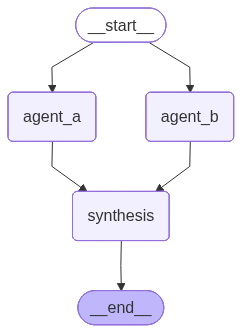

In [15]:
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
result = app.invoke({"query": "The future of AI agent frameworks like LangGraph and ADK"})

🔹 Agent A: Researching technical details...
🔹 Agent B: Researching business perspective...
🔹 Synthesizing combined responses...


In [17]:
print("\n✅ Final Combined Summary:\n")
print(result["messages"][-1].content)


✅ Final Combined Summary:

The future of AI agent frameworks like LangGraph and ADK is set to revolutionize business operations by enhancing efficiency, reducing costs, and improving customer experiences. These frameworks will enable the development of scalable, customizable AI agents that automate routine tasks, provide data-driven insights, and support real-time processing. As businesses leverage these technologies, they can innovate faster, gain competitive advantages, and offer personalized services. However, this transformation will also require addressing challenges related to interoperability, security, and ethical considerations, ensuring that AI solutions are both effective and responsible.
